In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# function takes result file and returns GO_ID and array of coefficients
def map_GO_to_GTEX():
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)



    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                map_GO_to_GTEX[GO_ID] = map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]

    inputFile.close()
    return map_GO_to_GTEX

def get_coeff(results):
    read_coeff = 0
    read_perfo = 0
    coeffs = []
    tissues = []
    pred = []
    label = []
    tissueMap = {}
    for line in results:
        data = line.rstrip('\n').split('\t')
        # print data[0]
        if data[0] == '# Prediction results for:':
            GO_ID = data[1]    
        elif data[0] == '# ROC AUC score:':
            AUC = float(data[1])
        elif data[0] == '# tissue':
            tissues.append(data[2])
            tissueMap[data[2]] = []
        elif data[0] == '# Coefficients:':
            read_coeff = 1
            i = 0      
        elif data[0] == '# Gene ID':
            read_coeff = 0
            read_perfo = 1
        elif read_perfo == 1 and (data[0]):
            label.append(int(data[1]))
            pred.append(float(data[2]))
        elif read_coeff == 1 and (data[0]):
            t_idx = int(data[0])-1
            coeff = float(data[1])
            tissueMap[tissues[t_idx]].append(coeff) 
    # print GO_ID,'AUC:', AUC
    results.close()
    return [GO_ID, tissueMap, AUC, label, pred]

def load_all_go(input_file):
    GO_list = []
    gene_count = []
    results = open(input_file)
    skip = 2
    i_line = 0
    for line in results:
        if i_line < skip:
            i_line += 1
            continue
        data = line.rstrip('\n').split('\t')
        GO_list.append(data[0])
        gene_count.append(int(data[1]))
    results.close()
    return [GO_list, gene_count]

def plot_roc(fprs, tprs, title):
    plt.figure()
    for (fpr, tpr) in zip(fprs, tprs):
        plt.plot(fpr, tpr, 'gray')
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the 50% line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_roc_heat(fprs, tprs, gene_cnts, title):
 
    NCURVES = len(gene_cnts)
    xs = fprs

    fig = plt.figure()
    ax = fig.add_subplot(111)

    cmap = plt.cm.YlOrRd
    min_count = int(min(gene_cnts))
    max_count = int(max(gene_cnts))
    # print min_count, max_count
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count/2))

    for idx in range(NCURVES):
        colorVal = scalarMap.to_rgba(gene_cnts[idx])
        ax.plot(fprs[idx], tprs[idx], color=colorVal)
        
    ax.plot([0, 1], [0, 1], 'black')  # Plot the 50% line       

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label('# of Genes')
    #cbar.set_ticks(gene_cnts)
    #cbar.set_ticklabels(['{:4.1f}'.format(yi) for yi in y]) # Make 'em nicer-looking

    ax.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    
def make_roc_curves_grplasso(GO_terms_map, GO_cnts):
    false_pos_rates = []
    true_pos_rates = []
    GO_terms_list = GO_terms_map.keys()
    gene_counts = [GO_cnts[term] for term in GO_terms_list]
    sorted_tuples = sorted(zip(GO_terms_list, gene_counts), key=lambda tup: tup[1], reverse=False)
    GO_terms_list = [tup[0] for tup in sorted_tuples]
    gene_counts = [tup[1] for tup in sorted_tuples]
    auc_scores = []

    for term in GO_terms_list:
        (cur_labels, cur_probs) = GO_terms_map[term]
        # print cur_probs
        # print cur_labels
        for j, pred in enumerate(cur_probs):
            if pred == 0:
                cur_probs[j] = 1.0 - cur_probs[j]
        cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_probs)
        
        #cur_fpr, cur_tpr, _ = roc_curve(cur_labels, cur_decs)
        false_pos_rates.append(cur_fpr)
        true_pos_rates.append(cur_tpr)
        auc_scores.append(roc_auc_score(cur_labels, cur_probs))

    plot_roc(false_pos_rates, true_pos_rates, 'ROC for Log Transformed Expressions')
    plot_roc_heat(false_pos_rates, true_pos_rates, gene_counts, 'ROC for Log Transformed Expressions')
    
    plt.plot(gene_counts,auc_scores, "o")
    plt.xlabel('Gene Counts')
    plt.ylabel('AUC Score')
    ax = plt.gca()
    ax.grid()
    plt.show()

    return auc_scores
    

In [3]:
# function takes GO term, array of coefficients, and (optional) highlighted tissues, and plots accordingly
def plot_coeff(GO_ID, nGenes, AUC, tissueMap, highlight = []):
    # samples = open('../data/samples_to_tissues_map.txt')
    # tissue_type = np.loadtxt(samples,dtype='S40',delimiter='\t')
    # tissue_list = pd.unique(tissue_type[:,2]) # pandas maintains correct order, numpy doesn't
    
    tissue_list = []
    coeffs = []
    x = []
    for index, key in enumerate(sorted(tissueMap)):
        tissue_list.append(key)
        for coeff in tissueMap[key]:
            coeffs.append(abs(coeff))
            x.append(index)
    
    # x = [np.where(tissue_list == tissue)[0][0] for tissue in tissue_type[:,2]]
    plt.figure(figsize=(18, 4))
    plt.plot(x, coeffs, 'bo')
    plt.margins(0.01)
    ax = plt.gca()
    ax.xaxis.grid(which='both')
    # You can specify a rotation for the tick labels in degrees or with keywords.
    plt.xticks(range(len(tissue_list)), tissue_list, rotation='vertical')
    # Pad margins so that markers don't get clipped by the axes
    
    # Tweak spacing to prevent clipping of tick-labels
    # plt.subplots_adjust(bottom=0.15)
    plt.ylabel((GO_ID+'('+str(nGenes)+' genes) - AUC:'+str(AUC)))
    plt.show()
    
    
    """
    tissue_type = np.zeros((8555,3),dtype=np.str)
    row = -1
    
    for sample in samples:
        if row < 0:
            row = row + 1
            continue
        tissue_type[row,:] = sample.split('\t')
    print tissue_type
    """

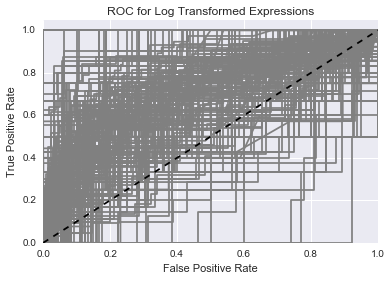

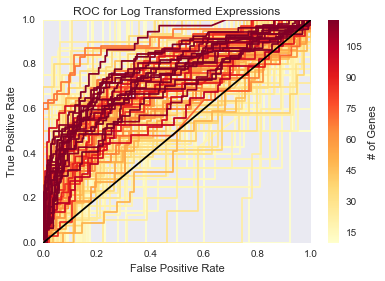

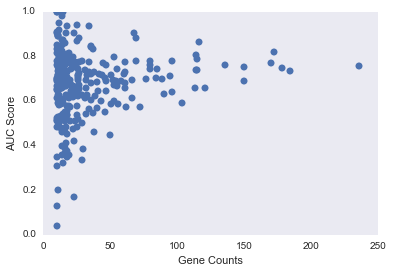

0.6810233772


In [6]:
GO_list, gene_counts = load_all_go('../data/GO_terms_final_gene_counts.txt')

GO_test_map = {}
GO_cnts = {}
for i in range(len(GO_list)):
    input_name = '../data/grplasso_results/grplasso_'+GO_list[i]+'_1.txt'
    try:
        results = open(input_name)
    except:
        print GO_list[i]+' not used because grplasso could not compute!'
        continue
    [GO_ID, tissueMap, AUC, label, pred] = get_coeff(results)
    GO_test_map[GO_list[i]] = (label,pred)
    GO_cnts[GO_list[i]] = gene_counts[i]
auc_scores = make_roc_curves_grplasso(GO_test_map, GO_cnts)
print(np.median(auc_scores))

In [44]:
# Get tissue for each coefficient
inputFilename = '../data/samples_to_tissues_map.txt'
sample_file = open(inputFilename)
sample_list = np.loadtxt(sample_file,skiprows=1,usecols=[2],dtype='S40',delimiter='\t')
tissue_types = np.unique(sample_list)
sample_file.close()

# Get list of GO_IDs
inputFilename = '../data/GO_terms_final_gene_counts.txt'
GO_list_file = open(inputFilename)
GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
GO_list_file.close()

# Create dataframe to of binary tissue firing matrix
tissue_firing = pd.DataFrame(1e-8, columns=GO_list, index=tissue_types)

for i,key in enumerate(GO_test_map):
    input_name = '../data/grplasso_results/grplasso_'+key+'_0.txt'
    try:
        results = open(input_name)
    except:
        print GO_list[i]+' not found!'
        continue
    [GO_ID, tissueMap, AUC, label, pred] = get_coeff(results)
    # GOmap = map_GO_to_GTEX()
    # tissues = GOmap[GO_ID]
    # print GO_ID,'# of genes:',GO_cnts[key],'AUC:', auc_scores[i]
    # plot_coeff(GO_ID, GO_cnts[key], auc_scores[i], tissueMap,highlight = tissues)
    tissue_list = []
    coeffs = []
    x = []
    for index, key in enumerate(sorted(tissueMap)):      
        for coeff in tissueMap[key]:
            tissue_list.append(key)
            coeffs.append(abs(coeff))
            x.append(index)
    coeffs = np.array(coeffs,dtype='float')    
    idx = np.where(abs(coeffs) > 1e-10)[0]
    GO_ID = GO_ID[1:-1]
    # tissues that have non-zero coefficients
    non_zero_tissues = np.unique(np.array(tissue_list)[idx])
    for tissue in non_zero_tissues:
        tissue = tissue[1:-1]
        # print GO_ID, tissue
        tissue_firing[GO_ID][tissue] = 1

In [32]:
tissue_types
tissue

'Skin-NotSunExposed(Suprapubic)'

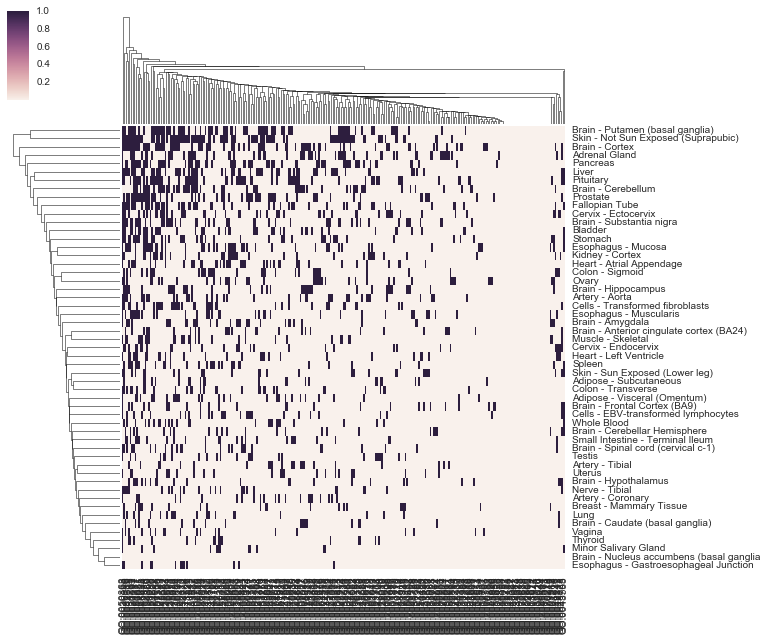

In [42]:
# Clustering heatmap of fired tissues
cluster = sns.clustermap(tissue_firing,metric='jaccard')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

In [7]:
np.percentile(auc_scores,25), np.percentile(auc_scores,50), np.percentile(auc_scores,75)

(0.52546296296296302, 0.66666666666666663, 0.7528313437404347)

 GO:0007596  # of genes: 150 AUC: 1.0


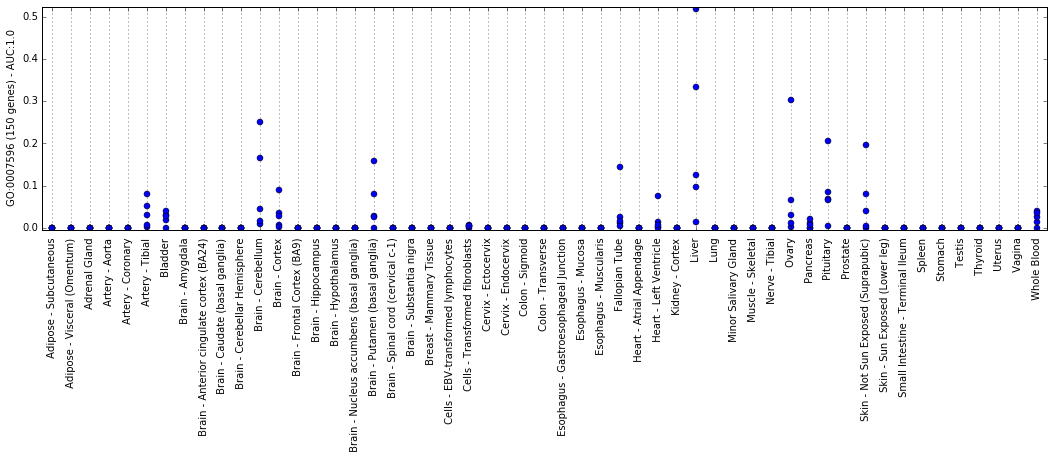

 GO:0008584  # of genes: 34 AUC: 1.0


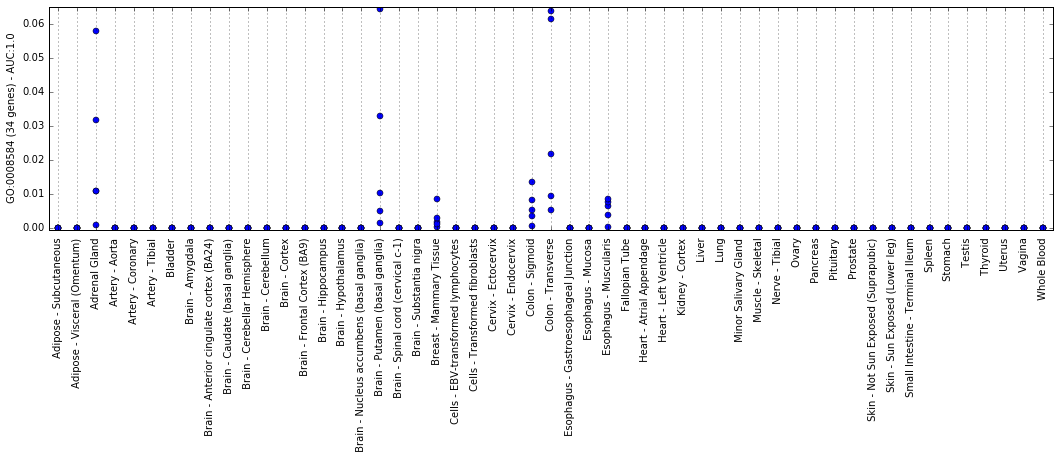

 GO:0003091  # of genes: 32 AUC: 1.0


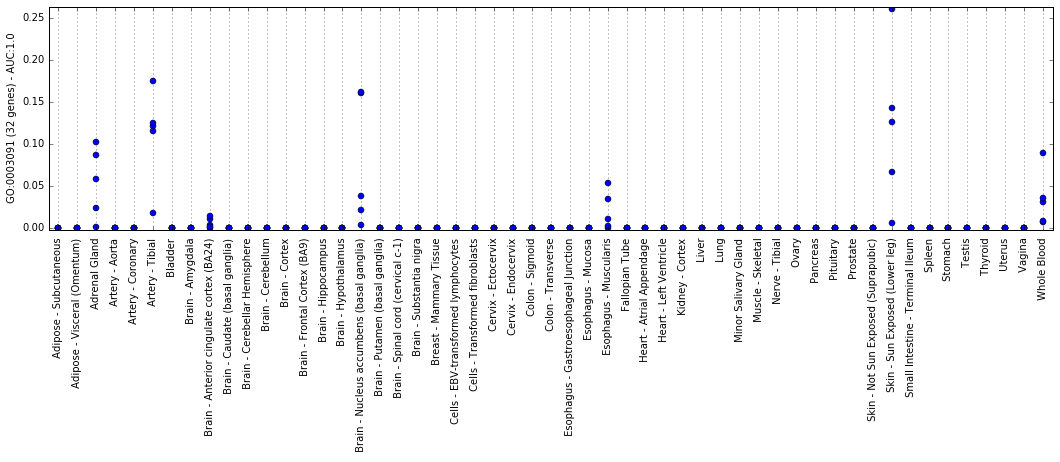

 GO:0048514  # of genes: 36 AUC: 0.888888888889


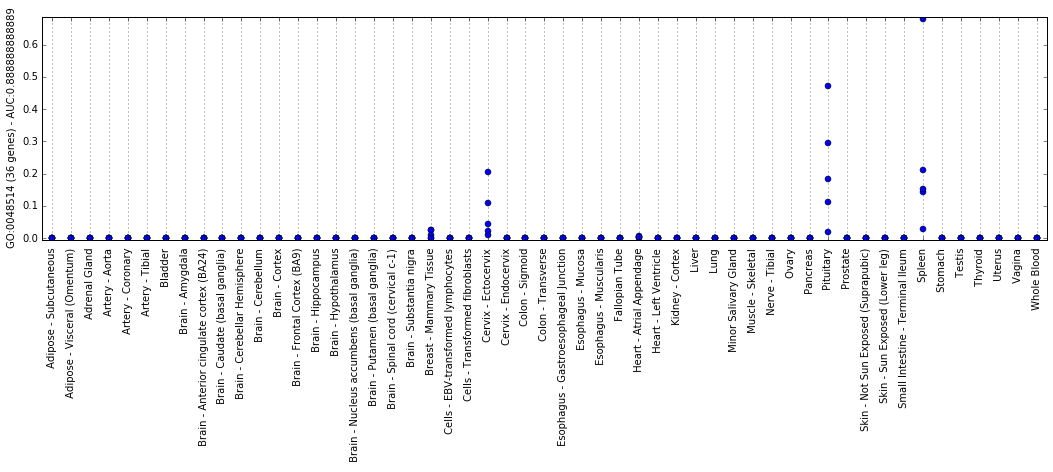

 GO:0043537  # of genes: 23 AUC: 0.9375


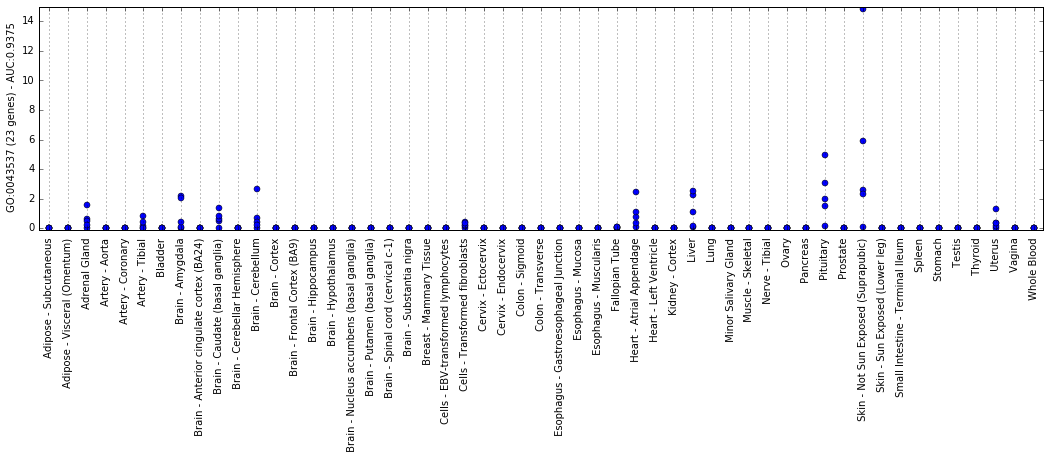

 GO:0043535  # of genes: 44 AUC: 0.875


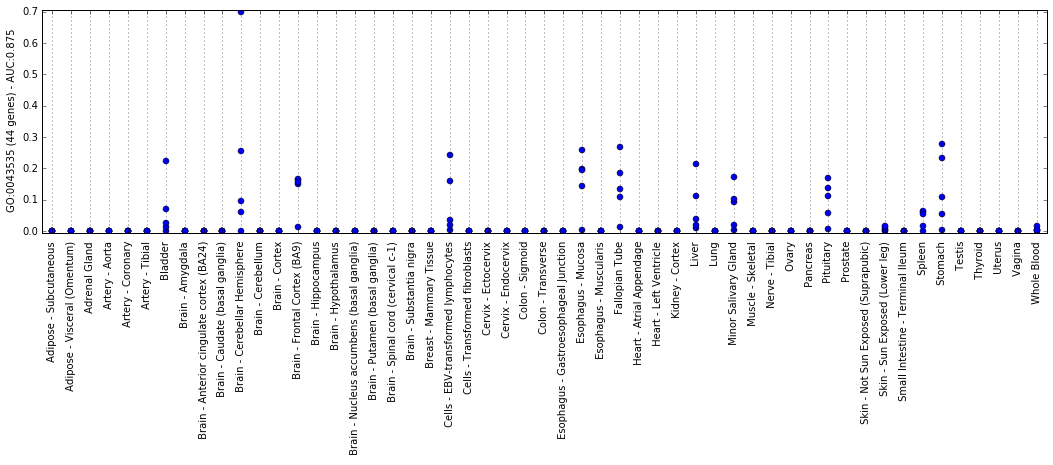

 GO:0030193  # of genes: 69 AUC: 0.875


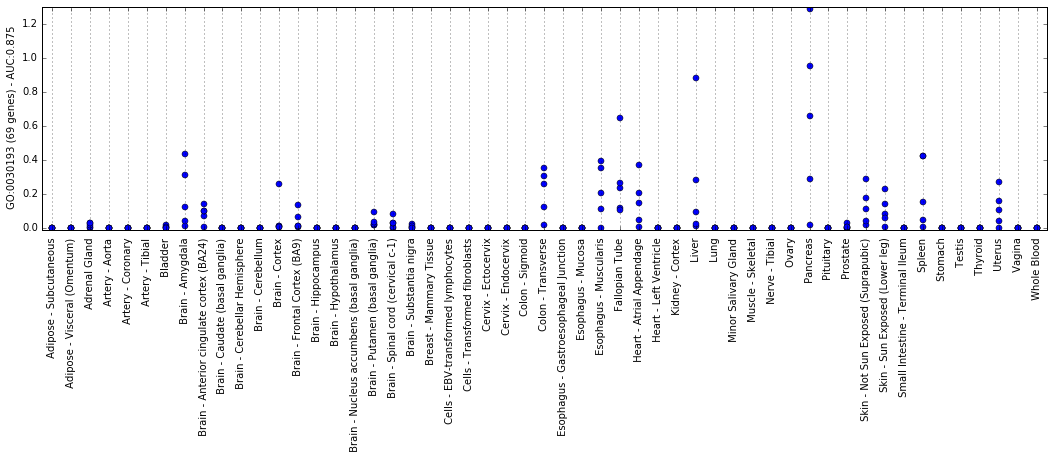

 GO:0060411  # of genes: 26 AUC: 0.9375


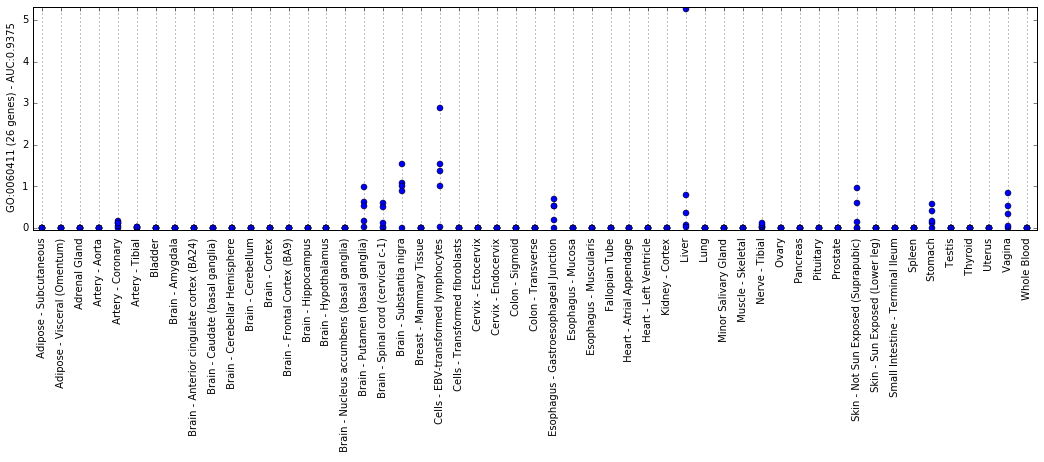

 GO:0046006  # of genes: 26 AUC: 0.875


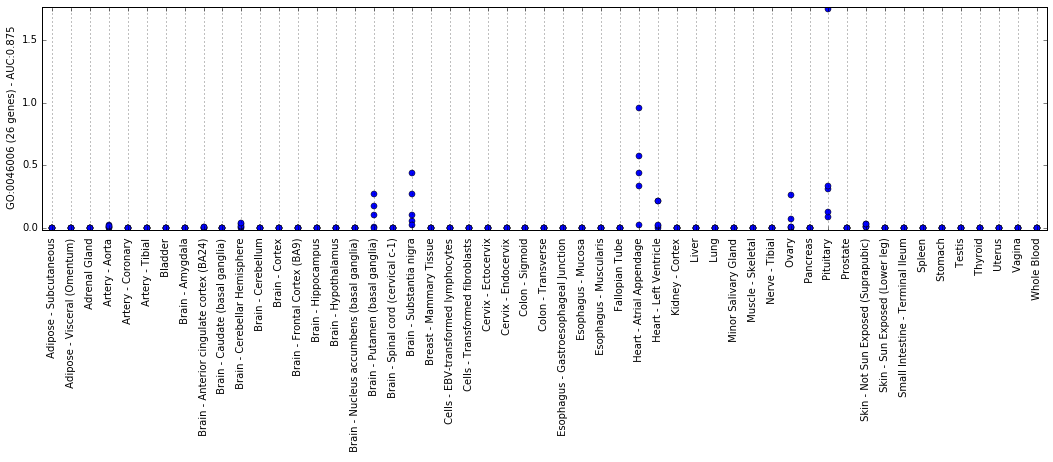

 GO:0042312  # of genes: 21 AUC: 0.88


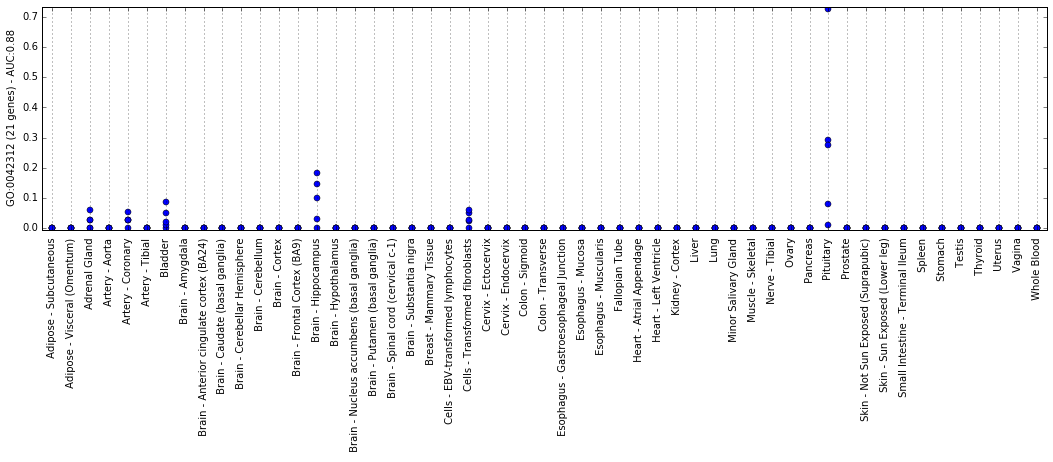

 GO:0010543  # of genes: 26 AUC: 0.92


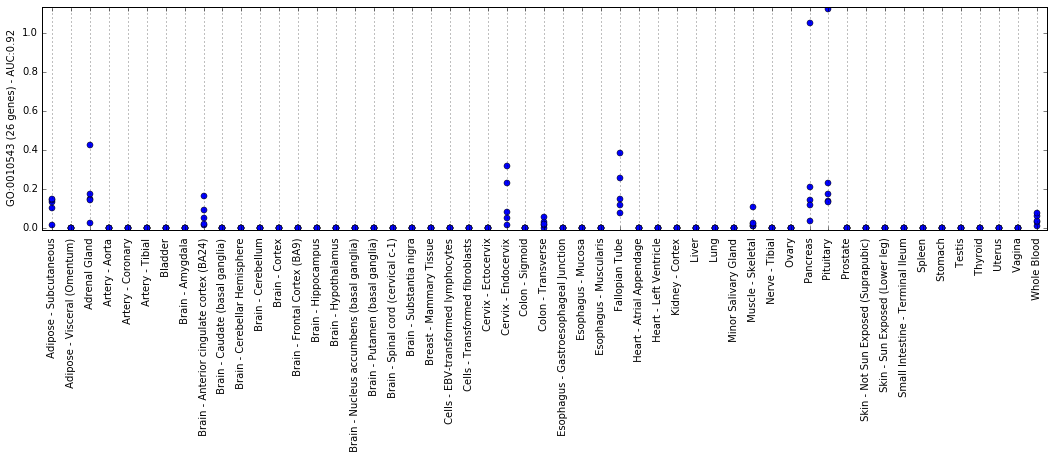

 GO:0030890  # of genes: 24 AUC: 0.96


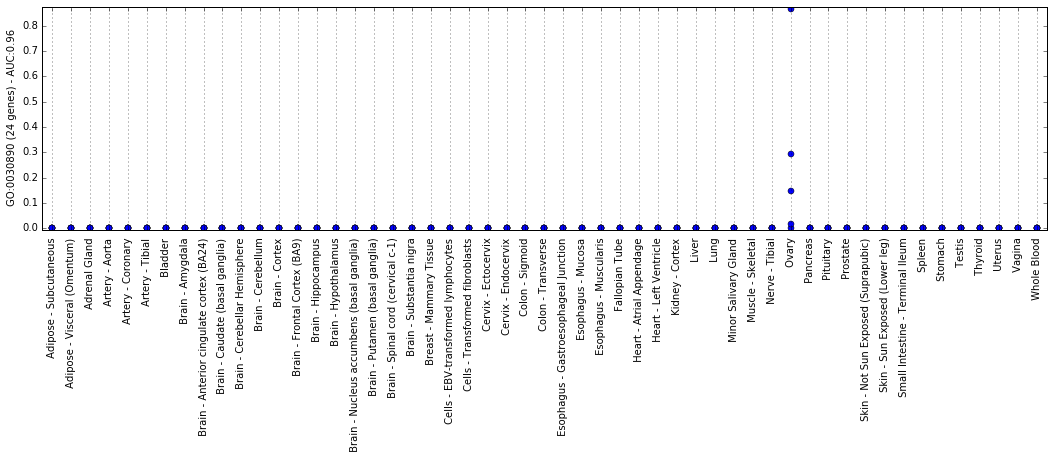

 GO:0001570  # of genes: 24 AUC: 0.833333333333


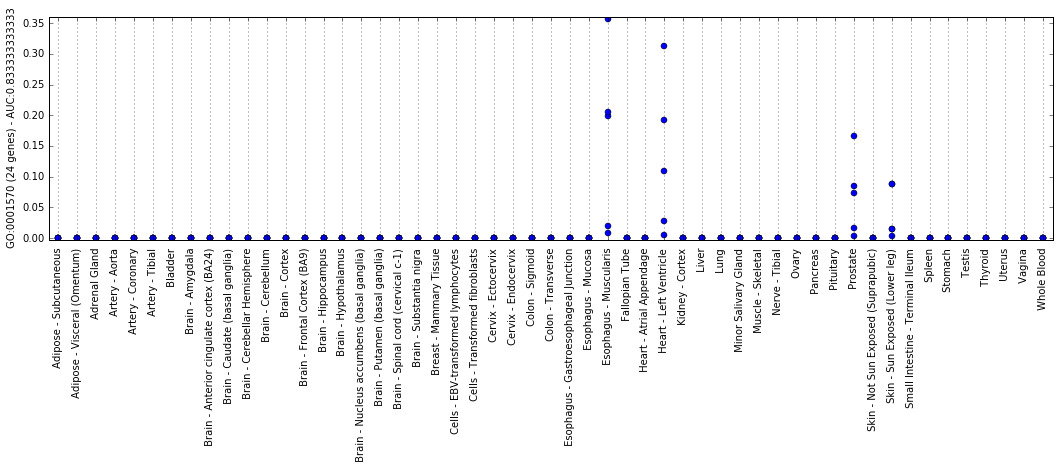

 GO:0045637  # of genes: 104 AUC: 0.833333333333


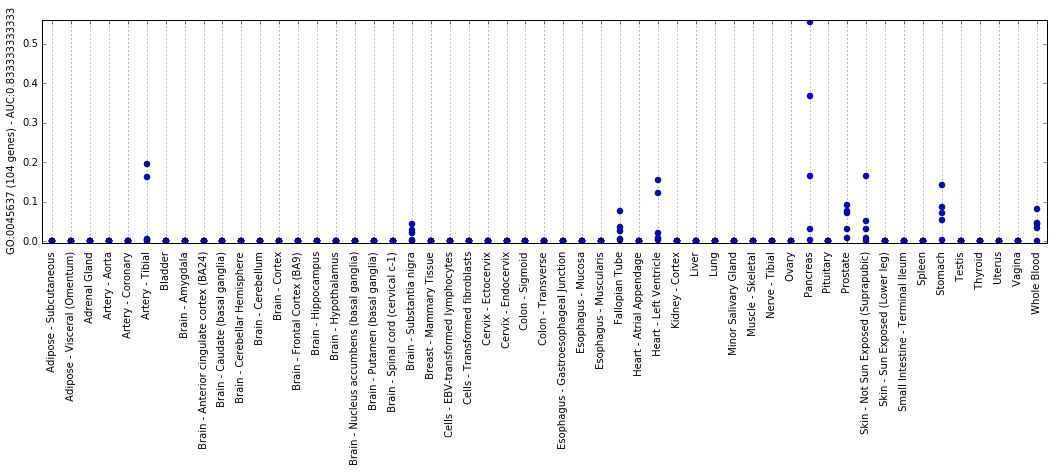

 GO:0030888  # of genes: 37 AUC: 0.857142857143


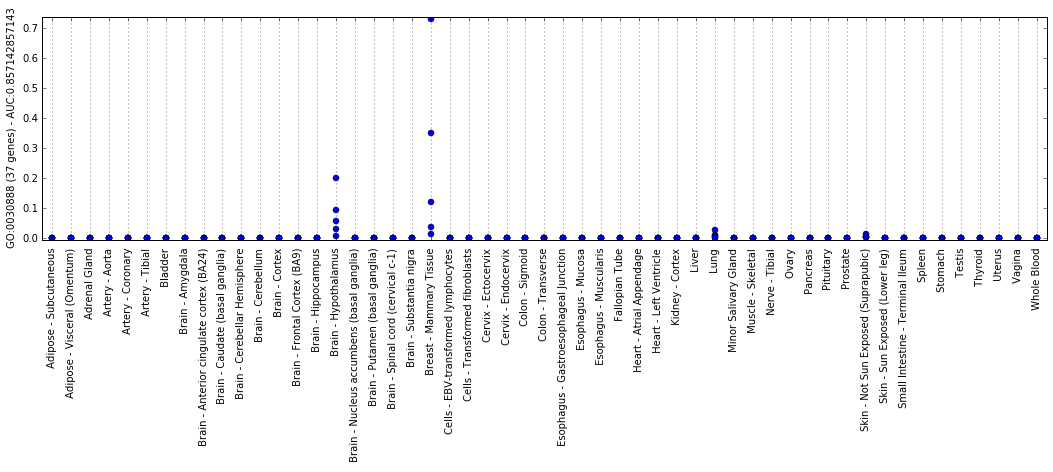

 GO:0008544  # of genes: 68 AUC: 0.918367346939


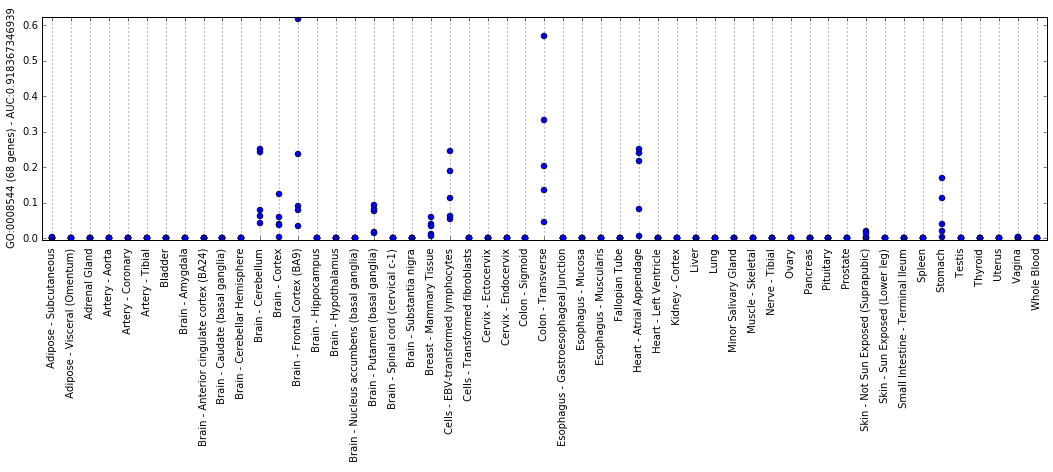

 GO:0001947  # of genes: 34 AUC: 0.890625


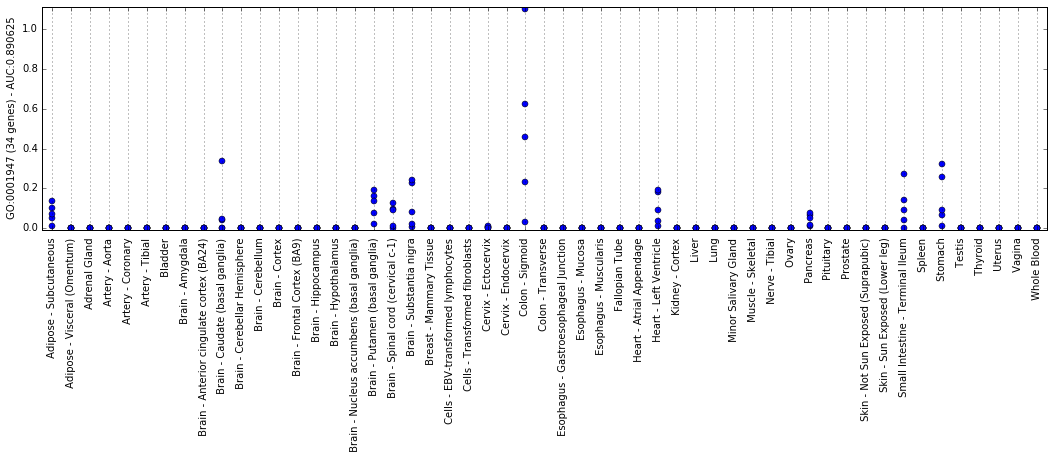

 GO:0045620  # of genes: 23 AUC: 1.0


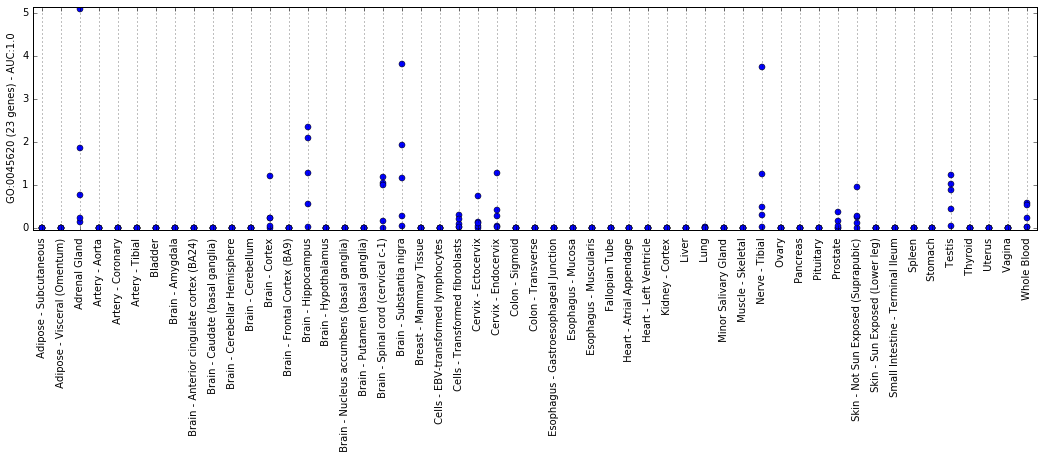

 GO:0042110  # of genes: 114 AUC: 0.89


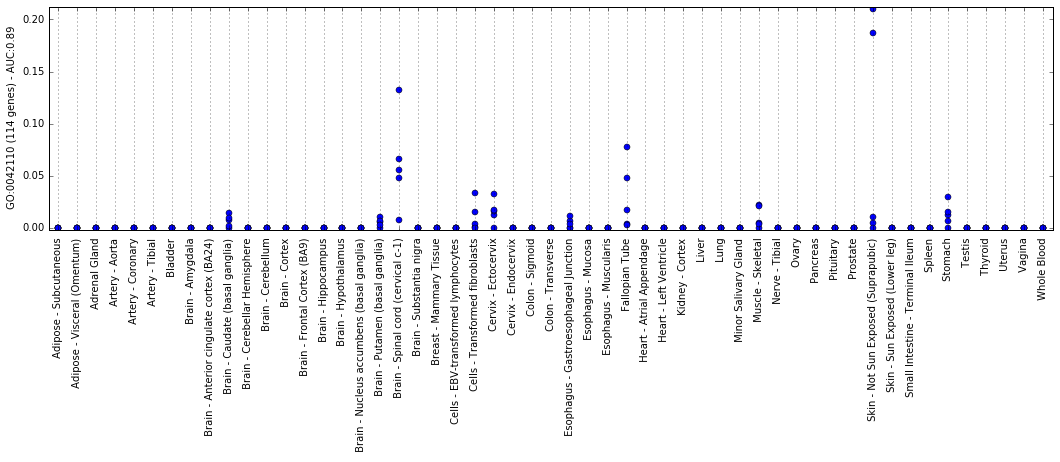

 GO:0042113  # of genes: 84 AUC: 0.80612244898


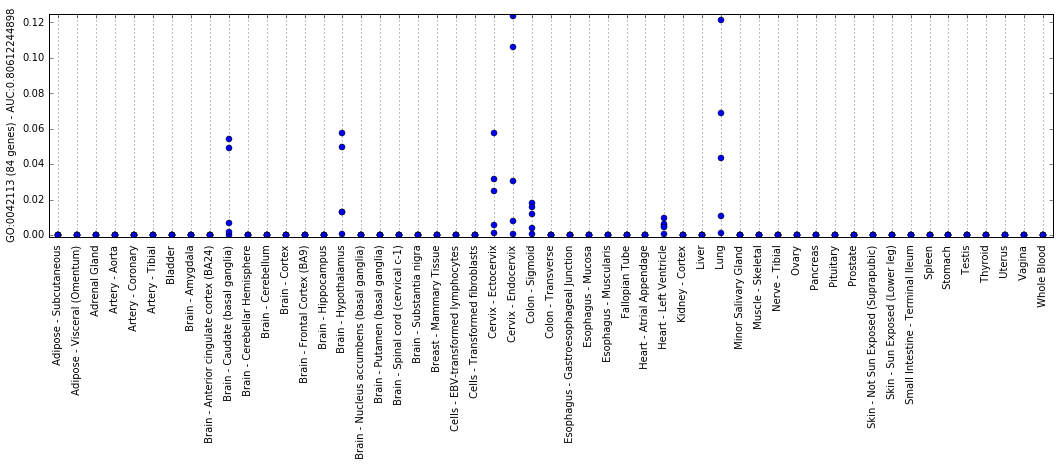

 GO:0050852  # of genes: 115 AUC: 0.81


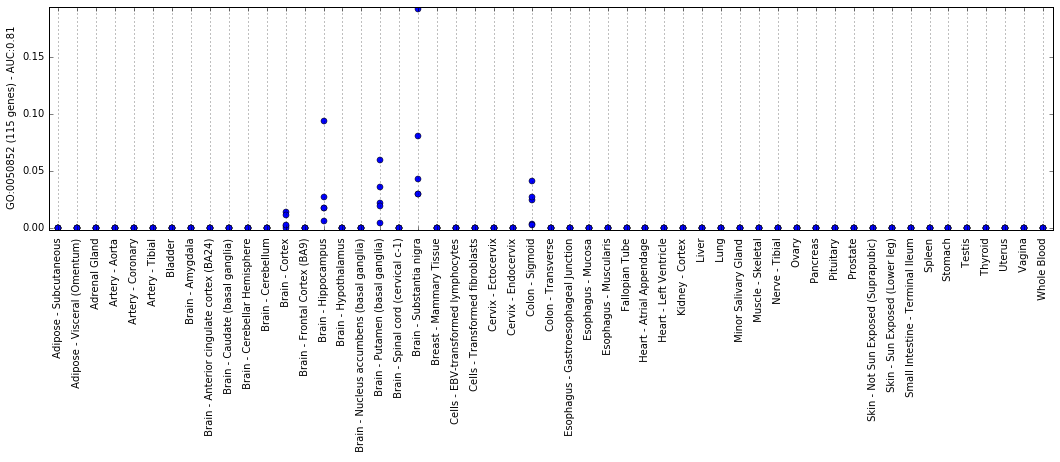

 GO:0061337  # of genes: 60 AUC: 0.807851239669


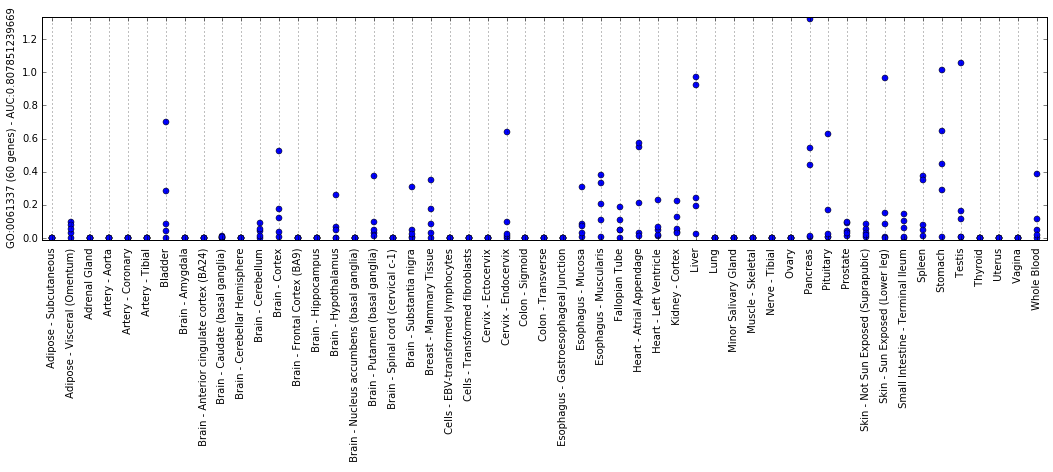

 GO:0007507  # of genes: 89 AUC: 0.891779396462


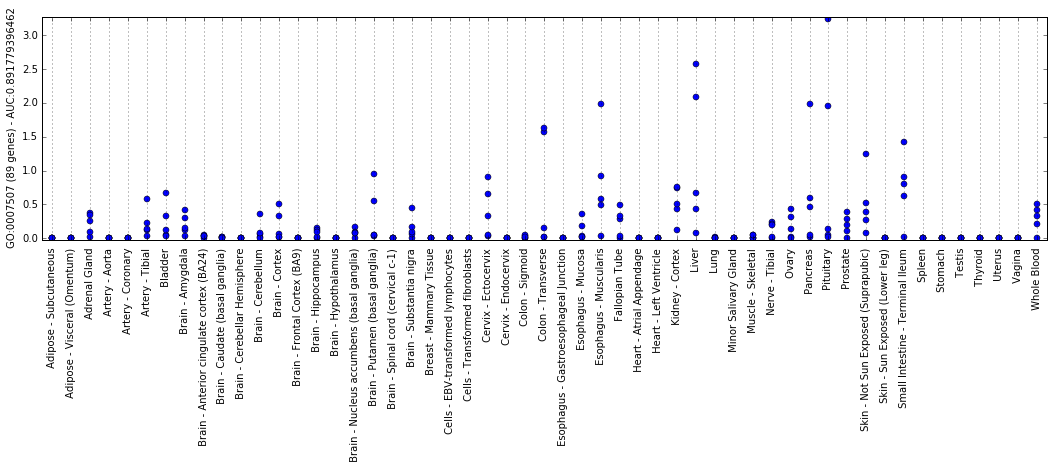

In [11]:
for i,key in enumerate(GO_test_map):
    input_name = '../data/grplasso_results/grplasso_'+key+'_0.txt'
    if auc_scores[i] > 0.8 and GO_cnts[key] > 20:
        try:
            results = open(input_name)
        except:
            print GO_list[i]+' not found!'
            continue
        [GO_ID, tissueMap, AUC, label, pred] = get_coeff(results)
        # GOmap = map_GO_to_GTEX()
        # tissues = GOmap[GO_ID]
        print GO_ID,'# of genes:',GO_cnts[key],'AUC:', auc_scores[i]
        # plot_coeff(GO_ID, GO_cnts[key], auc_scores[i], tissueMap,highlight = tissues)
        plot_coeff(GO_ID, GO_cnts[key], auc_scores[i], tissueMap)